In [1]:
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt

def semimajor_a(e, c0, m1, m2, G):
    """
    Semimajor axis as a function of eccentricity for a binary
    Peters 1964 eqn. 5.48, a(e)
    :param e: float
        eccentricity of the binary
    :param c0: float
        initial conditions factor
    :param m1: float
        mass_1 of binary
    :param m2: float
        mass_2 of binary
    :param G: float
        gravitational constant
    :return:
        a: float
            semimajor axis distance
    """
    frac = (e**(12.0/19)) / (1 - e**2)
    return c0 * frac * (1 + (121.0/304)*e**2)**(870.0/2299)

def semimajor_a_root(e, a, c0, m1, m2, G):
    """
    Wrapper function for semimajor_a root finding. 
        Ie. rootfinding for an `e` such that semimajor_a(e) = a
        solving for `e` when we have `a`.
    """
    a_new = semimajor_a(e, c0, m1, m2, G)
    return a - a_new

def get_c0(e, a, m1, m2, G):
    """
    Solve for the initial condition which describes the orbit
    :param e: float
        eccentricity
    :param a: float
        semimajor axis distance
    :param m1: float
        mass_1 of binary
    :param m2: float
        mass_2 of binary
    :param G: float
        gravitational constant
    :return:
        c0: float
            initial condition
    """
    # We solve the separation eqn. for a=a0, e=e0
    # see Peters 1964 eqn. 5.48, a(e)
    frac = (e**(12.0/19)) / (1 - e**2)
    c0 = a / (frac * (1 + (121.0/304)*e**2)**(870.0/2299))
    return c0


def period_to_semimajor_a(P, m1, m2, G):
    """
    Convert orital period into semimajor axis distance
    using Kepler's third law
    https://en.wikipedia.org/wiki/Kepler%27s_laws_of_planetary_motion#Third_law_of_Kepler
    :param P: float
        orbital period
    :param m1: float
        mass_1 of binary
    :param m2: float
        mass_2 of binary
    :param G: float
        gravitational constant
    :return:
        a: float
            semimajor axis distance
    """
    proportionConst = G*(m1 + m2) / (4*np.pi**2)
    a = (proportionConst * P**2)**(1.0/3)
    return a

def eccentricity_at_shifted_frequency(f, e0, f_ref, m1, m2, G):
    """
    Find the eccentricity at a different reference frequency
    :param f: float
        new reference frequency
    :param e0: float
        old eccentricity value at frequency `f_ref`
    :param f_ref: float
        old reference frequency
    :param m1: float
        mass_1 of binary
    :param m2: float
        mass_2 of binary
    :param G: float
        gravitational constant
    :return:
        e: float
            new eccentricity
    """
    
    # We take f_ref and convert this into an orbital period 
    # (!! assumes one orbital cycle == 1 GW period)
    P0 = 1.0/f_ref
    
    # Using Kepler's third law we convert the orbital period into a semimajor axis distance
    a0 = period_to_semimajor_a(P0, m1, m2, G)
    
    # Solve for the initial conditions which describe the orbit
    c0 = get_c0(e0, a0, m1, m2, G)
    
    # The period of the orbit at the new reference frequency
    P_new = 1.0/f
    # The new semimajor axis distance of the orbit.
    a_new = period_to_semimajor_a(P_new, m1, m2, G)
    
    # Scalar case
    #e_new = optimize.brentq(semimajor_a_root, 1e-16, 1-1e-16, args=(a_new, c0, m1, m2, G))
    
    # Vector arithmetic
    # Solve for e in a(e) = a_new
    e_new = optimize.root(semimajor_a_root, e0, args=(a_new, c0, m1, m2, G)).x
    return e_new


m_s = 9.989e30
G=6.674e-11

m1 = 1.5 * m_s
m2 = 1.6 * m_s
f_ref = 30
e = 0.0001

c0 = get_c0(e, f_ref, m1, m2, G)
new_e = eccentricity_at_shifted_frequency(20, e, f_ref, m1, m2, G)
print("Going from 30Hz to 20Hz takes e from {:.10f} to {:.10f}".format(e, new_e[0]))

new_e = eccentricity_at_shifted_frequency(f_ref, eccentricity_at_shifted_frequency(100, e, f_ref, m1, m2, G), 100, m1, m2, G)
print("Going from 30Hz to 100Hz, back to 30Hz takes e from {:.10f} to {:.10f}".format(e, new_e[0]))

Going from 30Hz to 20Hz takes e from 0.0001000000 to 0.0001534172
Going from 30Hz to 100Hz, back to 30Hz takes e from 0.0001000000 to 0.0001000000


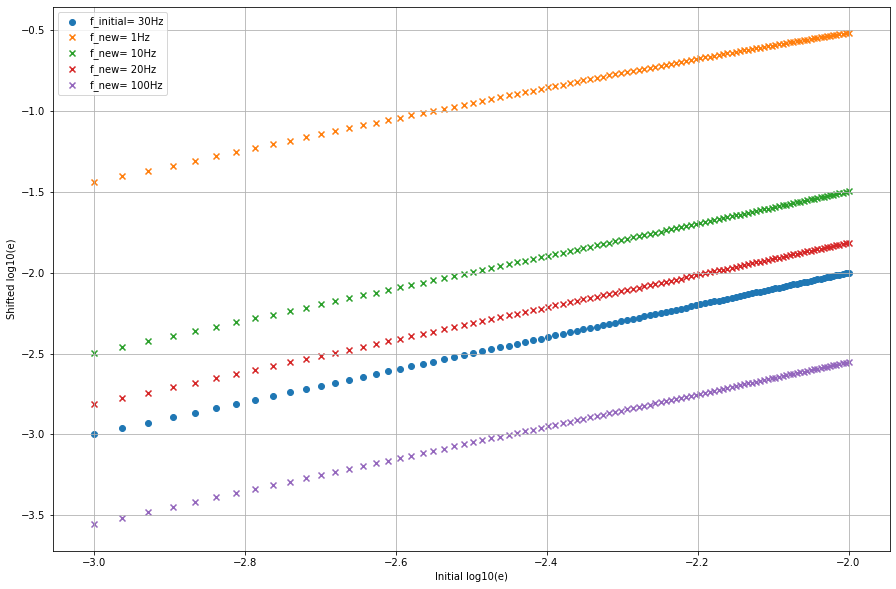

In [2]:
plt.figure(figsize=(15,10))

x = np.linspace(0.001, 0.01, 100)
plt.scatter(np.log10(x), np.log10(x), label="f_initial= {}Hz".format(30))

for f in [1, 10, 20, 100]:
    y = eccentricity_at_shifted_frequency(f, x, 30, m1, m2, G)
    plt.scatter(np.log10(x), np.log10(y), label="f_new= {}Hz".format(f), marker='x')
plt.legend()
plt.ylabel("Shifted log10(e)")
plt.xlabel("Initial log10(e)")
plt.grid()
plt.show()

/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py36/lib/python3.6/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in power


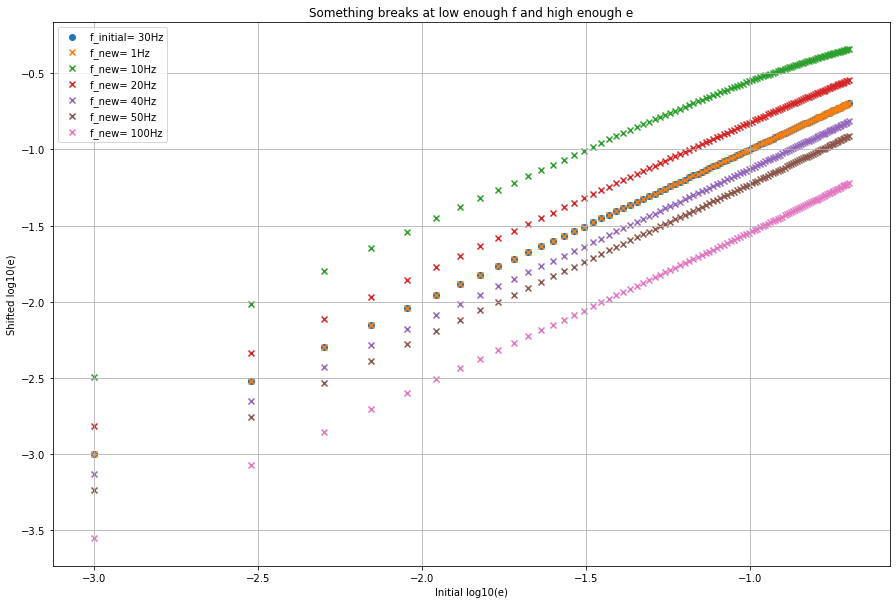

In [3]:
plt.figure(figsize=(15,10))

x = np.linspace(0.001, 0.2, 100)
plt.scatter(np.log10(x), np.log10(x), label="f_initial= {}Hz".format(30))

for f in [1, 10, 20, 40, 50, 100]:
    y = eccentricity_at_shifted_frequency(f, x, 30, m1, m2, G)
    plt.scatter(np.log10(x), np.log10(y), label="f_new= {}Hz".format(f), marker='x')
plt.title("Something breaks at low enough f and high enough e")
plt.legend()
plt.ylabel("Shifted log10(e)")
plt.xlabel("Initial log10(e)")
plt.grid()
plt.show()